# Imports
Import keras libraries

In [ ]:
from keras.models import Model, Sequential

from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)

from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras import utils
from keras import callbacks

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob, os
import xml.etree.ElementTree as ET


# Mount Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Parameters definition
Define all constants and variables to use in the process

In [ ]:
# data params
img_rows = 128
img_cols = 128
img_channels = 3

n_classes = 5
output_shape = n_classes

# training params
batch_size = 64
epochs = 100

# dictionary of classes name and associated integer id
voc = {
    'Vitex agnus-castus': 0,
    'Fraxinus angustifolia': 1,
    'Liquidambar styraciflua': 2,
    'Ruscus aculeatus': 3,
    'Phillyrea angustifolia': 4
}

#Data Loading
Load data from the provided path and return a tuple of two elements: the list of all images and the list of the groundtruth classes

In [ ]:
def loadDataset(path):
  images = []
  classes = []
  
  # parse each xml file 
  for file in glob.glob(path + "*.xml"):
    root = ET.parse(file).getroot()

    # extract the class of the image described by the current xml file
    classID = root.find('ClassId').text

    # extract the path of the image described by the current xml file and load it
    image_name = root.find('FileName').text
    img = Image.open(path + image_name)

    # resize the image in order to make it squared
    w, h = img.size
    w_size = min(w, h)/2

    img.crop((w/2-w_size, w/2+w_size, h/2-w_size, h/2+w_size))

    img = img.resize((img_rows, img_cols))

    classes.append(int(voc[classID]))
    images.append(np.asarray(img))

  return (np.array(images), np.array(classes))

Read the training and testing sets with labels and normalize the values

In [ ]:
# Load datasets

train_path = '/content/gdrive/My Drive/train/'
test_path = '/content/gdrive/My Drive/test/'

(X_train, y_train) = loadDataset(train_path)
(X_test, y_test) = loadDataset(test_path)

# cast images to 32 bits floating point numpy arrays
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# reshape numpy arrays and define the input shape depending on the keras backend
if (K.image_data_format=='channels_first'):
  X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
  
else:
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
  input_shape = (img_rows, img_cols, img_channels)

# Convert class vectors to binary class matrices
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

# normalize images
X_train /= 255.
X_test /= 255.

# Model definition
Define the model to be created with all its layers.<br>
We applied 3 blocks of two 2D Convolutional layers with increasing filters number (only 3x3 kernel size) going from 64 to 256 and with Relu activation function, followed by Max pooling layers (only 2x2 kernel size) to halve the resolution. A final single convolution with 512 and Max pooling is applied.<br>
We took inspiration from the VGG architecture, which is used for image classification tasks.

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Model compilation
Compile the model with multiclass Cross Entropy loss function and Adam optimizer. This loss function is the most used in image classification together with softmax activation function.

In [ ]:
# model compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 58, 58, 128)       147584    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 27, 27, 256)     

# Model training
Train the model on the training set, using as validation data the test datasets.

In [ ]:
my_callbacks = [
  callbacks.ModelCheckpoint(filepath='model.best.h5', mode='max', save_best_only=True)
]
epochs = 30

# model training
history = model.fit(
    X_train, Y_train,                   #train on the training set
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose = 1,
    validation_data = (X_test, Y_test), # validate on the test set
    callbacks=my_callbacks
)

Train on 821 samples, validate on 78 samples
Epoch 1/30
821/821 [==============================] - 5s 6ms/step - loss: 1.4774 - accuracy: 0.3715 - val_loss: 1.5745 - val_accuracy: 0.0256
Epoch 2/30
821/821 [==============================] - 5s 6ms/step - loss: 1.1826 - accuracy: 0.5189 - val_loss: 0.8005 - val_accuracy: 0.7949
Epoch 3/30
821/821 [==============================] - 5s 6ms/step - loss: 0.6255 - accuracy: 0.7625 - val_loss: 0.5831 - val_accuracy: 0.8205
Epoch 4/30
821/821 [==============================] - 5s 6ms/step - loss: 0.4360 - accuracy: 0.8356 - val_loss: 0.5593 - val_accuracy: 0.8462
Epoch 5/30
821/821 [==============================] - 5s 6ms/step - loss: 0.3340 - accuracy: 0.8831 - val_loss: 0.4551 - val_accuracy: 0.8462
Epoch 6/30
821/821 [==============================] - 5s 6ms/step - loss: 0.2393 - accuracy: 0.9281 - val_loss: 0.3928 - val_accuracy: 0.8846
Epoch 7/30
821/821 [==============================] - 5s 6ms/step - loss: 0.2185 - accuracy: 0.9111 - v

# Model testing
Test the model on the test set

In [ ]:
# model testing
loss, metrics = model.evaluate(
    X_test,
    Y_test,
    batch_size=batch_size
)
print("the loss of the model is: ", loss)
print("the accuracy of the model is: ", metrics)

78/78 [==============================] - 0s 3ms/step
the loss of the model is:  0.13068474236971292
the accuracy of the model is:  0.9615384340286255


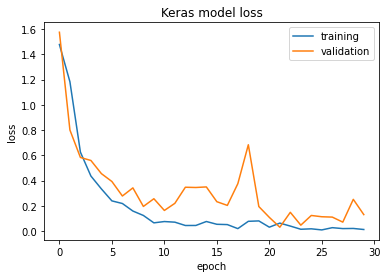

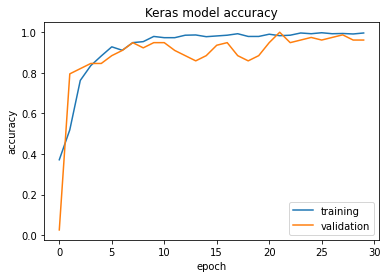

In [ ]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

Show the images that the model classify wrongly.

true class: 'Ruscus aculeatus'
guessed: 'Phillyrea angustifolia'


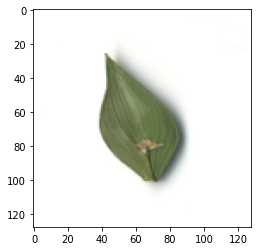

true class: 'Liquidambar styraciflua'
guessed: 'Ruscus aculeatus'


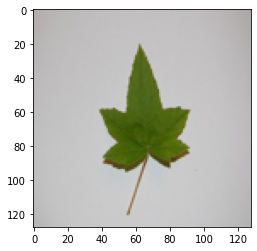

true class: 'Vitex agnus-castus'
guessed: 'Fraxinus angustifolia'


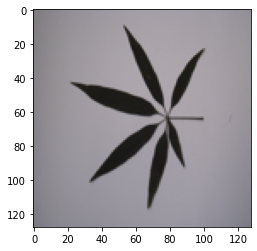

In [ ]:
# get the inverse dictionary of labels
inv_voc = {v: k for k, v in voc.items()}

# find those images who are misclassified
wrong = []
for i in range(len(X_test)):
  image =  X_test[i].reshape((1,) + X_test[i].shape)
  guess = np.argmax(model.predict(image)[0])
  if guess != np.argmax(Y_test[i]):
    wrong.append(i)

#show the misclassified images
for img in wrong:
  plt.figure()
  plt.imshow(X_test[img])
  print("true class: '" + inv_voc[np.argmax(Y_test[img])] + "'")
  print("guessed: '" + inv_voc[np.argmax(model.predict(X_test[img].reshape((1,) + X_test[img].shape))[0])] + "'")
  plt.show()